# 3D CNN over 11x11 single-station-sub-rasters
** Features: Precipitation, Mean-Air-Temperature **

Ausgabe: Veränderung Messstand 4 Wochen nach letztem Messstand zu letztem Messstand

Eingabe:
- 11x11 (ca. 11kx11km) Raster wöchentlich summierter Niederschlag für 12 Wochen vor letztem Messstand
- 11x11 monatl. Durchschnittstemperatur für die 3 vorkommenden Monate
- 3 letzte Messstände in einem Abstand von 4 Wochen als Differenz zum jeweiligen Stand 4 WOchen zuvor

In [1]:
import numpy as np
import pandas as pd
import rasterio as rio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import glob 
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, accuracy_score
import datetime


%load_ext tensorboard

In [2]:
data_drive = r'G:/'

## 1. load Data

In [3]:
stammdaten = pd.read_excel(data_drive +r'GruV-Net/data/Stammdaten_HE.xlsx')
stammdaten.set_index('Proj_ID', inplace=True)
gw_weekly = pd.read_csv(data_drive +r'GruV-Net/data/groundwater_levels_preprocessed_hesse/weekly/gw_lvl_complete.csv')
gw_weekly.set_index('Datum', inplace=True)

In [4]:
rws_folder = data_drive + r'GruV-Net/data/precipitation/weekly-sum/GTiff/'

rws_files = glob.glob(rws_folder+'*2008*.tif') + glob.glob(rws_folder+'*2009*.tif') + glob.glob(rws_folder+'*2010*.tif') + glob.glob(rws_folder+'*2011*.tif') + glob.glob(rws_folder+'*2012*.tif') +glob.glob(rws_folder+'*2013*.tif') + glob.glob(rws_folder+'*2014*.tif') + glob.glob(rws_folder+'*2015*.tif') + glob.glob(rws_folder+'*2016*.tif') + glob.glob(rws_folder+'*2017*.tif')
rws_files.sort()
temp_folder = data_drive + r'GruV-Net/data/temperature/GTiff/'

In [5]:
def assemble_instances(regnie_files, temp_path):
    x_regnie = []
    x_temp = []
    x_gw = []
    y = []
    instances_list = []

    regnie_file_names = list(map(os.path.basename, regnie_files))

    for i in range(0, len(regnie_files)-15):
        regnie_srcs =  []
        for l in range(1,13):
            #print(regnie_files[i+l])
            regnie_srcs.append(rio.open(regnie_files[i+l]))
        temp_srcs = []
        for l in (1, 5, 9):
            #Monatsauswahl noch tricky
            #print(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif')
            temp_srcs.append(rio.open(temp_path+'TAMM_'+ regnie_file_names[i+l][9:11]+'_'+regnie_file_names[i+l][4:8]+'_01.tif'))

        stations = gw_weekly.loc[regnie_file_names[i][4:14], : ].dropna().index.tolist()
        for s in stations:

            instance_desc = []
            instance_desc.append(s)
            east = stammdaten.loc[s]['OSTWERT']
            north = stammdaten.loc[s]['NORDWERT']
            row, col = regnie_srcs[0].index(east, north)

            instance_regnie = np.ndarray(shape=(12,11,11,1))
            # das ist noch ein Problem, manche Stationen zu nah am Rand
            try:
                for j in range(12):
                    r = regnie_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_regnie[j] = r.reshape((11,11,1))
                    instance_desc.append(regnie_srcs[j].name[48:-4])
            except ValueError:
                continue

            instance_temp = np.ndarray(shape=(3,11,11,1))
            try:
                for j in range(3):
                    r = temp_srcs[j].read(1, window=rio.windows.Window(col-5, row-5, 11, 11))
                    instance_temp[j] = r.reshape((11,11,1))
                    instance_desc.append(temp_srcs[j].name[35:-4])
            except ValueError:
                continue

            instance_gw = []
            try:    
                for k in [4, 8, 12, 16]:
                    #lieber in Prozent?
                    change =  gw_weekly.loc[regnie_file_names[i+k][4:14], : ][s] - gw_weekly.loc[regnie_file_names[i+k-4][4:14], : ][s]
                    if np.isnan(change):
                        raise Exception()
                    else: 
                        instance_gw = np.append(instance_gw, change)
                        instance_desc.append(regnie_file_names[i+k][4:14])
                        instance_desc.append(change)
            except Exception:
                continue 

            x_regnie.append(instance_regnie)
            x_temp.append(instance_temp)
            x_gw.append(instance_gw[:3])
            instances_list.append(instance_desc)
            y = y + list(instance_gw[3:])
    return np.array(x_regnie), np.array(x_temp), np.array(x_gw), np.array(y), instances_list

In [6]:
X_regnie, X_temp, X_gw, y, instances_list = assemble_instances(rws_files, temp_folder)

In [7]:
print(X_regnie.shape)
print(X_temp.shape)
print(X_gw.shape)
print(y.shape)

(193906, 12, 11, 11, 1)
(193906, 3, 11, 11, 1)
(193906, 3)
(193906,)


In [8]:
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_NEW.npy', X_regnie)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_NEW.npy', X_temp)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_NEW.npy', X_gw)
np.save(data_drive +r'GruV-Net/data/assembled_instances/cnn/Y_2008-2017_NEW.npy', y)

In [9]:
pd.DataFrame(instances_list).to_csv(data_drive +r'GruV-Net/data/assembled_instances/cnn/instance-list_2008-2017_NEW.csv')

## 2. Define and train CNN

In [3]:
X_regnie = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_NEW.npy')
X_temp = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_temp_2008-2017_NEW.npy')
X_gw = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_gw_2008-2017_NEW.npy')
y = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/y_2008-2017_NEW.npy')

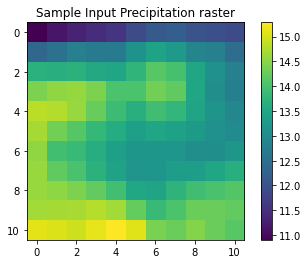

In [10]:
plt.imshow(X_regnie[0][0].reshape((11,11)))
plt.title("Sample Input Precipitation raster")
plt.colorbar()

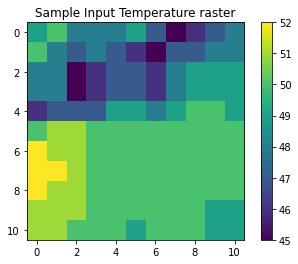

In [11]:
plt.imshow(X_temp[0][0].reshape((11,11)))
plt.title("Sample Input Temperature raster")
plt.colorbar()

In [12]:
regnie_input = keras.Input(shape=(12, 11, 11, 1), name="regnie")
temp_input = keras.Input(shape=(3, 11, 11, 1), name="temp")
gw_input = keras.Input(shape=(3), name="gw")

regnie_features = layers.Conv3D(64, 3, data_format='channels_last')(regnie_input)
regnie_features = layers.MaxPooling3D(pool_size=(3))(regnie_features)
regnie_features = layers.Flatten()(regnie_features)
temp_features = layers.Conv3D(64, (1,3,3), data_format='channels_last')(temp_input)
temp_features = layers.MaxPooling3D(pool_size=(1,3,3))(temp_features)
temp_features = layers.Flatten()(temp_features)
env_features = layers.concatenate([regnie_features, temp_features])
env_features = layers.Dense(64)(env_features)
x = layers.concatenate([env_features, gw_input])
x = layers.Dense(32)(x)
pred = layers.Dense(1)(x)

GruV = keras.Model(
    inputs=[regnie_input, temp_input, gw_input],
    outputs=[pred],
)

![Model Architecture](img/model-architecture.png)

In [13]:
GruV.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error',tf.keras.metrics.RootMeanSquaredError()])
GruV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
regnie (InputLayer)             [(None, 12, 11, 11,  0                                            
__________________________________________________________________________________________________
temp (InputLayer)               [(None, 3, 11, 11, 1 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 10, 9, 9, 64) 1792        regnie[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 3, 9, 9, 64)  640         temp[0][0]                       
______________________________________________________________________________________________

In [14]:
hist = []
preds = []
trues = []
cv_round = 1

for train_idx, test_idx in TimeSeriesSplit(5).split(X_regnie):
    X_regnie_train, X_regnie_test = X_regnie[train_idx], X_regnie[test_idx]
    X_temp_train, X_temp_test = X_temp[train_idx], X_temp[test_idx]
    X_gw_train, X_gw_test = X_gw[train_idx], X_gw[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    regnie_scaler = preprocessing.StandardScaler().fit(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1))
    temp_scaler = preprocessing.StandardScaler().fit(X_temp_train.reshape(*X_temp_train.shape[:1], -1))
    gw_scaler = preprocessing.MaxAbsScaler().fit(X_gw_train)

    X_regnie_train = regnie_scaler.transform(X_regnie_train.reshape(*X_regnie_train.shape[:1], -1)).reshape((len(train_idx), 12, 11, 11, 1))
    X_regnie_test = regnie_scaler.transform(X_regnie_test.reshape(*X_regnie_test.shape[:1], -1)).reshape((len(test_idx), 12, 11, 11, 1))
    X_temp_train = temp_scaler.transform(X_temp_train.reshape(*X_temp_train.shape[:1], -1)).reshape((len(train_idx), 3, 11, 11, 1))
    X_temp_test = temp_scaler.transform(X_temp_test.reshape(*X_temp_test.shape[:1], -1)).reshape((len(test_idx), 3, 11, 11, 1))
    X_gw_train = gw_scaler.transform(X_gw_train)
    X_gw_test = gw_scaler.transform(X_gw_test)

    log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "-"+str(cv_round)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    h = GruV.fit(
    {"regnie": X_regnie_train, "temp": X_temp_train, "gw": X_gw_train},
    y_train,
    epochs=20,
    validation_data=({"regnie": X_regnie_test, "temp": X_temp_test, "gw": X_gw_test}, y_test),
    callbacks=[tensorboard_callback]
    )
    pred = GruV.predict({"regnie": X_regnie_test, "temp": X_temp_test, "gw": X_gw_test}).flatten()

    preds.append(pred)
    trues.append(y_test)
    hist.append(h)
    cv_round += 1

 - val_mean_absolute_error: 0.3294 - val_root_mean_squared_error: 0.6968
Train on 64638 samples, validate on 32317 samples
Epoch 1/20
64638/64638 [==============================] - 17s 269us/sample - loss: 0.4190 - mean_absolute_error: 0.2858 - root_mean_squared_error: 0.6473 - val_loss: 0.3349 - val_mean_absolute_error: 0.2853 - val_root_mean_squared_error: 0.5787
Epoch 2/20
64638/64638 [==============================] - 17s 267us/sample - loss: 0.4169 - mean_absolute_error: 0.2856 - root_mean_squared_error: 0.6457 - val_loss: 0.3370 - val_mean_absolute_error: 0.2878 - val_root_mean_squared_error: 0.5805
Epoch 3/20
64638/64638 [==============================] - 17s 264us/sample - loss: 0.4146 - mean_absolute_error: 0.2858 - root_mean_squared_error: 0.6439 - val_loss: 0.3222 - val_mean_absolute_error: 0.2662 - val_root_mean_squared_error: 0.5677
Epoch 4/20
64638/64638 [==============================] - 17s 265us/sample - loss: 0.4131 - mean_absolute_error: 0.2841 - root_mean_squared_er

In [15]:
np.save(data_drive +r'GruV-Net/data/model_eval/cnn/cnn_single_station_prc_temp_eval_preds_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.npy', preds)
np.save(data_drive +r'GruV-Net/data/model_eval/cnn/cnn_single_station_prc_temp_eval_trues_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")+'.npy', trues)

In [16]:
for i in range(5):
    print('Split ', i+1, ' - RSME: ',np.sqrt(mean_squared_error(trues[i], preds[i])))
    print('Split ', i+1, ' - MAE: ',mean_absolute_error(trues[i], preds[i]))
    print('Split ', i+1, ' - Median AE: ',median_absolute_error(trues[i], preds[i]))
    print('Split ', i+1, ' - Std. of AE: ',np.std(np.abs(trues[i] - preds[i])))
    print('Split ', i+1, ' - Trend Classification Acc.: ',accuracy_score(np.sign(trues[i]), np.sign(preds[i])))
    print('---')

Split  1  - RSME:  0.696844939799652
Split  1  - MAE:  0.3294311657031822
Split  1  - Median AE:  0.20928409337997778
Split  1  - Std. of AE:  0.6140586105477418
Split  1  - Trend Classification Acc.:  0.5603242875266887
---
Split  2  - RSME:  0.5719467190304585
Split  2  - MAE:  0.27115610871866747
Split  2  - Median AE:  0.1501232588291117
Split  2  - Std. of AE:  0.50358456500796
Split  2  - Trend Classification Acc.:  0.5655846767954946
---
Split  3  - RSME:  0.5946428855232713
Split  3  - MAE:  0.27267508526986806
Split  3  - Median AE:  0.15397525042294546
Split  3  - Std. of AE:  0.5284396457274119
Split  3  - Trend Classification Acc.:  0.5618095739084692
---
Split  4  - RSME:  0.7030525036491934
Split  4  - MAE:  0.3219176831630258
Split  4  - Median AE:  0.1802533927559864
Split  4  - Std. of AE:  0.6250214621549798
Split  4  - Trend Classification Acc.:  0.5333415849243432
---
Split  5  - RSME:  0.652788243257181
Split  5  - MAE:  0.3345736425715524
Split  5  - Median AE:  0

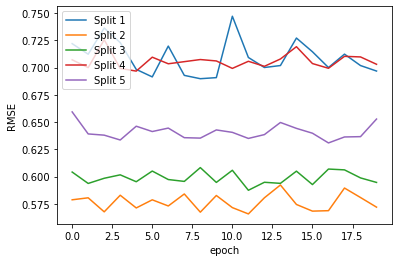

In [17]:
for i in range(5):
    plt.plot(hist[i].history['val_root_mean_squared_error'])
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['Split 1', 'Split 2', 'Split 3', 'Split 4', 'Split 5'], loc='upper left')
plt.show()

In [ ]:
%tensorboard --logdir logs/fit

## 3. Analysis

In [64]:
import seaborn as sns
sns.set_style("ticks")

In [8]:
instances_list = pd.read_csv(data_drive +r'GruV-Net/data/assembled_instances/cnn/instance-list_2008-2017_NEW.csv', index_col=0).to_numpy()

In [9]:
preds = np.load(data_drive +r'GruV-Net/data/model_eval/cnn/cnn_single_station_prc_temp_eval_preds_20201121-221237.npy')
trues = np.load(data_drive +r'GruV-Net/data/model_eval/cnn/cnn_single_station_prc_temp_eval_trues_20201121-221237.npy')
regnie = np.load(data_drive +r'GruV-Net/data/assembled_instances/cnn/X_regnie_2008-2017_NEW.npy')

In [10]:
for train_idx, test_idx in TimeSeriesSplit(5).split(instances_list):
    instances_list_train, instances_list_test = instances_list[train_idx], instances_list[test_idx]
    regnie_test = regnie[test_idx]

In [13]:
stations = np.unique(instances_list_test[:,0])

In [14]:
len(stations)

733

In [6]:
print(len(preds[4].flatten()))
print(len(trues[4]))
print(len(instances_list_test))
print(len(regnie_test))

32317
32317
32317
32317


In [34]:
station_rmse = [0]*len(stations)
for i in range(len(stations)):
    _pred = preds[4].flatten()[instances_list_test[:, 0:1].flatten() == stations[i]]
    _true = trues[4][instances_list_test[:, 0:1].flatten() == stations[i]]
    _rmse = np.sqrt(mean_squared_error(_true, _pred))
    station_rmse[i] = _rmse

In [35]:
print('worst station: ' + stations[np.argmax(station_rmse)])

worst station: HE_15725


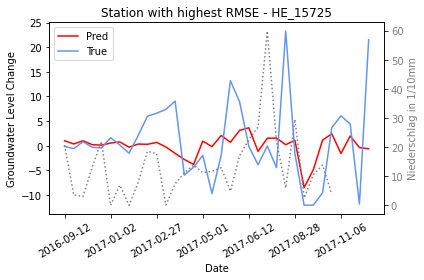

In [36]:
s = 'HE_15725'
_pred = preds[4].flatten()[instances_list_test[:, 0:1].flatten() == s]
_true = trues[4][instances_list_test[:, 0:1].flatten() == s]
_regnie = [r.flatten().mean() for r in regnie_test[instances_list_test[:, 0:1].flatten() == s][:,11]][4:]+[np.nan]*4

t = instances_list_test[instances_list_test[:, 0:1].flatten() == s][:,22]

fig, ax1 = plt.subplots()

ax1.set_title('Station with highest RMSE - '+ s)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel("Groundwater Level Change")
ax1.plot(t, _pred, 'r')
ax1.plot(t, _true, 'cornflowerblue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'grey'
ax2.set_ylabel('Niederschlag in 1/10mm', color=color)
ax2.plot(t, _regnie, color=color, linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(['Pred', 'True'], loc='upper left')
ax1.tick_params(axis='x', labelrotation=30)

fig.tight_layout()
plt.xticks(t[::5])
plt.show()

In [39]:
best_stations_idx = np.array(station_rmse).argsort()[:20]

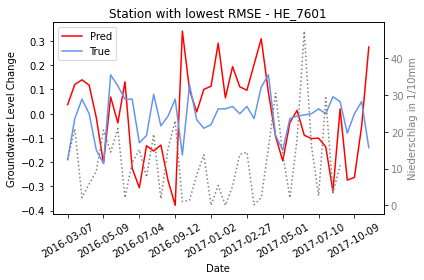

In [40]:
s = 'HE_7601'
_pred = preds[4].flatten()[instances_list_test[:, 0:1].flatten() == s]
_true = trues[4][instances_list_test[:, 0:1].flatten() == s]
_regnie = [r.flatten().mean() for r in regnie_test[instances_list_test[:, 0:1].flatten() == s][:,11]][4:]+[np.nan]*4

t = instances_list_test[instances_list_test[:, 0:1].flatten() == s][:,22]

fig, ax1 = plt.subplots()

ax1.set_title('Station with lowest RMSE - '+ s)

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel("Groundwater Level Change")
ax1.plot(t, _pred, 'r')
ax1.plot(t, _true, 'cornflowerblue')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()

color = 'grey'
ax2.set_ylabel('Niederschlag in 1/10mm', color=color)
ax2.plot(t, _regnie, color=color, linestyle='dotted')
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(['Pred', 'True'], loc='upper left')
ax1.tick_params(axis='x', labelrotation=30)

fig.tight_layout()
plt.xticks(t[::5])
plt.show()

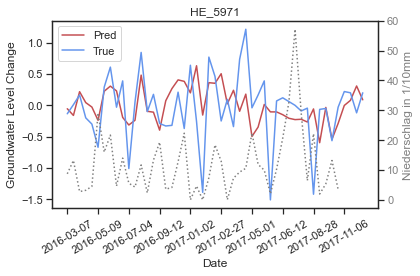

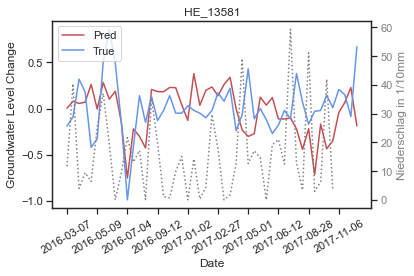

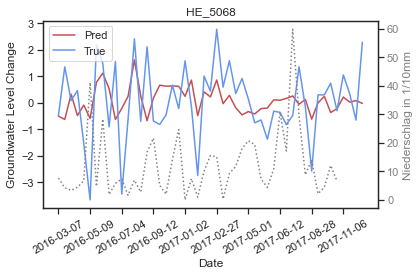

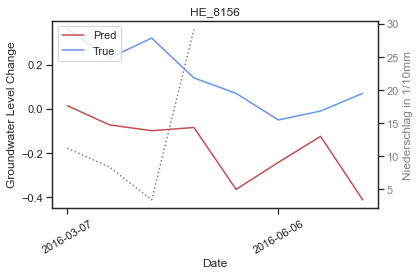

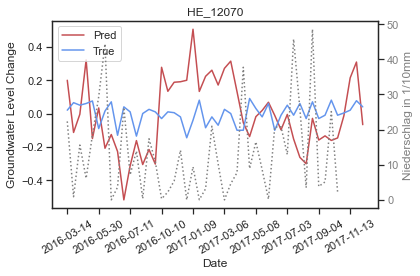

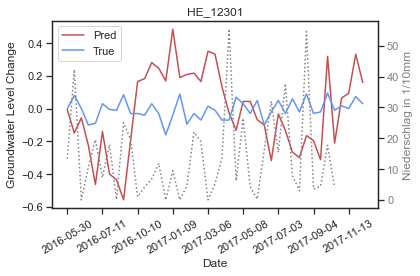

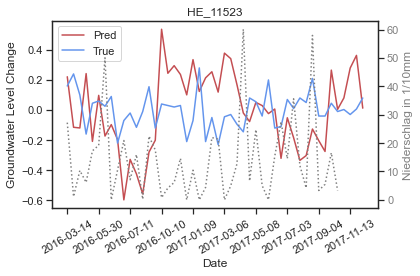

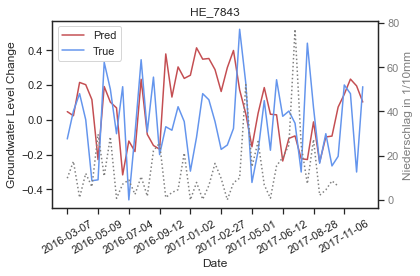

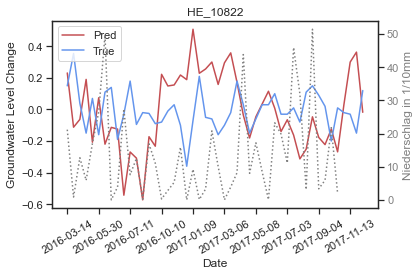

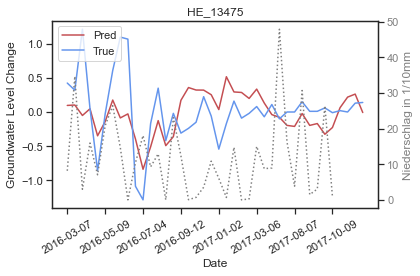

In [86]:
import random
stations = list(dict.fromkeys(instances_list_test[:, 0:1].flatten()))
rand_stations = random.sample(stations, 10)

for s in rand_stations:
    _pred = preds[4].flatten()[instances_list_test[:, 0:1].flatten() == s]
    _true = trues[4][instances_list_test[:, 0:1].flatten() == s]
    _regnie = [r.flatten().mean() for r in regnie_test[instances_list_test[:, 0:1].flatten() == s][:,11]][4:]+[np.nan]*4

    t = instances_list_test[instances_list_test[:, 0:1].flatten() == s][:,22]

    fig, ax1 = plt.subplots()

    ax1.set_title(s)

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel("Groundwater Level Change")
    ax1.plot(t, _pred, 'r')
    ax1.plot(t, _true, 'cornflowerblue')
    ax1.tick_params(axis='y')

    ax2 = ax1.twinx()

    color = 'grey'
    ax2.set_ylabel('Niederschlag in 1/10mm', color=color)
    ax2.plot(t, _regnie, color=color, linestyle='dotted')
    ax2.tick_params(axis='y', labelcolor=color)

    ax1.legend(['Pred', 'True'], loc='upper left')
    ax1.tick_params(axis='x', labelrotation=30)

    fig.tight_layout()
    plt.xticks(t[::5])
    plt.show()

In [4]:
ae = np.abs(preds[4].flatten() - trues[4])

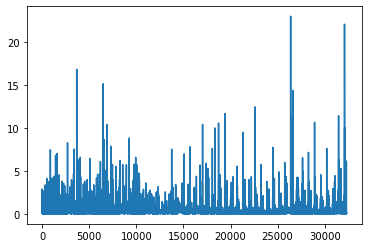

In [5]:
plt.plot(ae)

In [6]:
np.argmax(ae)

26382

In [7]:
worst_instances = (-ae).argsort()[:20]
worst_instances

array([26382, 32102,  3668,  6478, 26640, 22594, 19394, 31471, 26395,
       28922, 18727, 17031,  6875, 32163, 18338, 32115, 21306,  9235,
        6592,  2691], dtype=int64)

In [52]:
instances_list_test[26382]

array(['HE_15725', 'rws_2017-04-24', 'rws_2017-05-01', 'rws_2017-05-08',
       'rws_2017-05-15', 'rws_2017-05-22', 'rws_2017-05-29',
       'rws_2017-06-05', 'rws_2017-06-12', 'rws_2017-06-19',
       'rws_2017-06-26', 'rws_2017-07-03', 'rws_2017-07-10',
       'TAMM_04_2017_01', 'TAMM_05_2017_01', 'TAMM_06_2017_01',
       '2017-05-15', -1.9200000000000157, '2017-06-12',
       -0.15000000000000568, '2017-07-10', -0.04999999999998295,
       '2017-08-07', 23.269999999999985], dtype=object)

In [10]:
best_instances = (ae).argsort()[:20]
best_instances

array([23005,  3918, 21137, 29836, 30089,  6507, 21558, 13329, 12215,
        1737, 23377, 29855, 30979, 20747, 22751, 15365, 22962, 29539,
        4358,  2522], dtype=int64)

In [11]:
instances_list_test[23005]

array(['HE_12301', 'rws_2017-02-20', 'rws_2017-02-27', 'rws_2017-03-06',
       'rws_2017-03-13', 'rws_2017-03-20', 'rws_2017-03-27',
       'rws_2017-04-03', 'rws_2017-04-10', 'rws_2017-04-17',
       'rws_2017-04-24', 'rws_2017-05-01', 'rws_2017-05-08',
       'TAMM_02_2017_01', 'TAMM_03_2017_01', 'TAMM_04_2017_01',
       '2017-03-13', -0.009999999999990905, '2017-04-10',
       -0.07000000000000739, '2017-05-08', 0.030000000000001137,
       '2017-06-05', -0.09999999999999433], dtype=object)